# Introduction

In this notebook I will explain the program I wrote for our second competiton. I used several methods to make the data given cleaner and better for using to train my model. I used single imputer to impute missing values and onehotencoder to transform categorical values to numerical ones. Then I used the training set to train four algoritms, compare each of them, and pick the model that gives a closer prediction to our target.

# Problem Understanding

The objective of this project was to predict the target variable based on a syntetic train dataset. The dataset presented challenges such as missing values (null values) and mixed data types (non-numeric values), requiring robust preprocessing and feature engineering. The goal was to develop a reliable regression model that gave accurate predictions.

The first thing that I did was to import all the libraries that will be necessary for me to move further. Then I created two dataframes called "train" and "test" which includes the data that is given to us to work on.

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
# Load data
train = pd.read_csv(r'/kaggle/input/math482-2024-2025-1-hw-03/train.csv')
test = pd.read_csv(r'/kaggle/input/math482-2024-2025-1-hw-03/test.csv')




# Exploratory Data Analysis

With the code below, I gained a general understanding of our dataset. Nearly all of our features have null variables which should be filled or dropped ,and the datatypes included are either a float or an object.

In [2]:
train.info()
train.describe()
train.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          30000 non-null  int64  
 1   feature_01  27152 non-null  float64
 2   feature_02  27136 non-null  float64
 3   feature_03  27195 non-null  object 
 4   feature_04  27110 non-null  float64
 5   feature_05  27130 non-null  float64
 6   feature_06  27158 non-null  float64
 7   feature_07  27170 non-null  object 
 8   feature_08  27120 non-null  float64
 9   feature_09  27125 non-null  float64
 10  feature_10  27093 non-null  float64
 11  feature_11  27152 non-null  object 
 12  feature_12  27116 non-null  float64
 13  feature_13  27146 non-null  float64
 14  feature_14  30000 non-null  object 
 15  feature_15  27177 non-null  float64
 16  feature_16  27137 non-null  object 
 17  feature_17  27153 non-null  float64
 18  feature_18  27142 non-null  object 
 19  feature_19  27152 non-nul

,id,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,target
0,1,43.71,-90.85,u,-28.35,0.20,0.24,B1,NaN,14.65,...,2.98,ij,5.29,C3,8.0,A2,ab,D4,654.69,357.98
1,2,95.56,-9.20,NaN,-14.07,0.91,0.04,B3,106.68,2.41,...,0.86,ij,-12.72,C1,6.0,A4,ac,D1,2.83,1103.49
2,3,75.88,NaN,u,-8.50,0.50,0.13,B3,70.79,3.10,...,7.83,ii,-3.47,C2,1.0,A5,ab,D1,312.83,501.38
3,4,63.88,NaN,q,NaN,3.07,0.36,B6,90.18,1.07,...,0.73,ji,31.65,C1,3.0,A8,ad,D1,1.99,1174.88
4,5,24.04,-41.22,t,-32.25,4.86,0.42,B5,119.19,8.07,...,1.12,jj,-12.25,NaN,5.0,A7,NaN,NaN,0.85,1350.99


After preparing my train X and train y by assigning columns without target to Xtrain, and the target column itself to y_train; I created a plot showing the Distribution of the target variable, indicating the how many times a certain target value occurs. 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


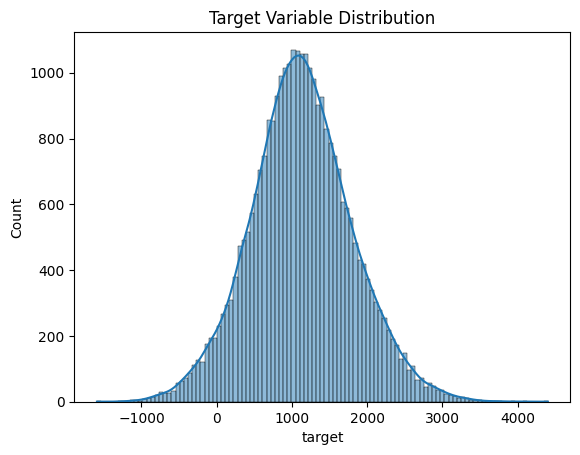

In [3]:
# Separate features and target
target_column = "target"
X_train_full = train.drop(columns=[target_column])
y_train_full = train[target_column]
X_test = test


import seaborn as sns
import matplotlib.pyplot as plt

# Target distribution
sns.histplot(y_train_full, kde=True)
plt.title("Target Variable Distribution")
plt.show()




# Solution Approach

## Preprocessing 

I used SimpleImputer to impute missing values. The most frequent value (mode) was used for categorical features, while the median was used for numerical features.

In [4]:

# Preprocessing
# Handle categorical columns
categorical_columns = X_train_full.select_dtypes(include=['object']).columns
imputer_cat = SimpleImputer(strategy='most_frequent')
X_train_full[categorical_columns] = imputer_cat.fit_transform(X_train_full[categorical_columns])
X_test[categorical_columns] = imputer_cat.transform(X_test[categorical_columns])

# Handle numerical columns
numerical_columns = X_train_full.select_dtypes(exclude=['object']).columns
imputer_num = SimpleImputer(strategy='median')
X_train_full[numerical_columns] = imputer_num.fit_transform(X_train_full[numerical_columns])
X_test[numerical_columns] = imputer_num.transform(X_test[numerical_columns])
print(numerical_columns)

Index(['id', 'feature_01', 'feature_02', 'feature_04', 'feature_05',
       'feature_06', 'feature_08', 'feature_09', 'feature_10', 'feature_12',
       'feature_13', 'feature_15', 'feature_17', 'feature_21'],
      dtype='object')


And now that I have the columns that have the float datatype, I wanted to see if there are any outliers that should be discluded from the training data. I used Z-score to understand this below. It ended up showing there are no significant outliers.

In [5]:
from scipy.stats import zscore
z_scores = train[numerical_columns].apply(zscore)

# Check for values with Z-scores greater than 3 or less than -3
outliers = (z_scores > 3) | (z_scores < -3)
outliers_sum = outliers.sum()
print(outliers_sum)

id            0
feature_01    0
feature_02    0
feature_04    0
feature_05    0
feature_06    0
feature_08    0
feature_09    0
feature_10    0
feature_12    0
feature_13    0
feature_15    0
feature_17    0
feature_21    0
dtype: int64


I applied OneHotEncoder to transform categorical features into numerical form, ensuring compatibility with machine learning models. The first category was dropped to avoid multicollinearity.

In [6]:

# OneHotEncode categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
X_train_encoded = encoder.fit_transform(X_train_full[categorical_columns])
X_test_encoded = encoder.transform(X_test[categorical_columns])

X_train_full = pd.concat([X_train_full.reset_index(drop=True), 
                          pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_columns))], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), 
                    pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_columns))], axis=1)


With the categorical column data are transformed into numerical values, I can safely drop the categorical columns without loosing information (eliminating object datatypes).
I created a heatmap and graph to understand the correlation between the numerical columns and target values in the upcoming code sections. From the data I gathered from those plots I decided on dropping 4 least correlated features from the full X train and test data.
Then I splitted my train data into train and test data to be able to check the accuracy rates of different models.


In [7]:

X_train_full.drop(columns=categorical_columns, inplace=True)
X_test.drop(columns=categorical_columns, inplace=True)

# Align columns
X_test = X_test.reindex(columns=X_train_full.columns, fill_value=0)

columnstodrop = ['feature_01', 'feature_06', 'feature_17', 'feature_21']
X_train_full.drop(columns=columnstodrop, inplace=True)
X_test.drop(columns=columnstodrop, inplace=True)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)



As indicated above, I wanted to see how the numerical columns were correlated with the target variables. To see those correlations I created a heatmap with the below code.

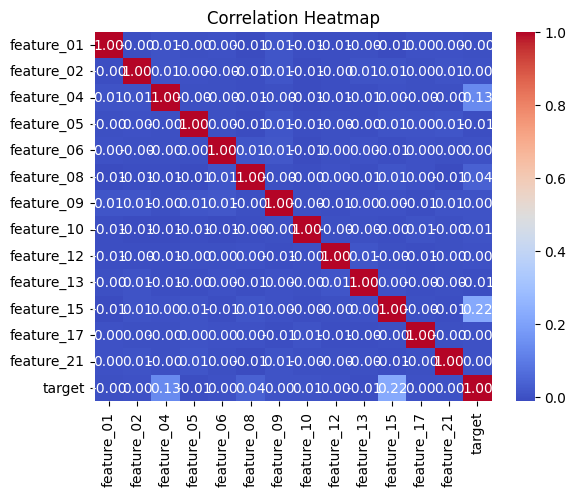

In [8]:
# Ensure numerical_columns is a list of column names
numerical_columns = ['feature_01', 'feature_02', 'feature_04', 'feature_05', 'feature_06', 'feature_08', 'feature_09', 'feature_10', 'feature_12', 'feature_13', 'feature_15', 'feature_17', 'feature_21']

# Define the target column
target_column = 'target'

# Combine numerical columns with the target column
columns_for_correlation = numerical_columns + [target_column]

# Verify that these columns exist in the DataFrame
missing_columns = [col for col in columns_for_correlation if col not in train.columns]
if missing_columns:
    print(f"Warning: The following columns are missing in the DataFrame: {missing_columns}")
else:
    # Compute the correlation matrix
    correlation_matrix = train[columns_for_correlation].corr()

    # Plot the heatmap
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.show()

After the table created , I also wanted to see the correlation values in reducing order in a figure plot, to get a clearer picture.

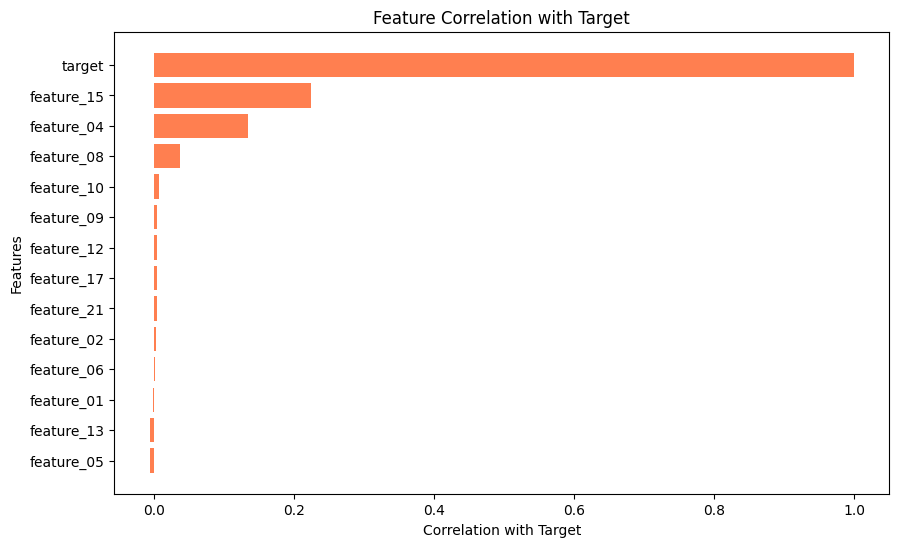

In [9]:
# Calculate correlations
correlation = train[columns_for_correlation].corrwith(y_train_full)

# Create a DataFrame for visualization
correlation_df = correlation.sort_values(ascending=False).reset_index()
correlation_df.columns = ['Feature', 'Correlation']

# Plot
plt.figure(figsize=(10, 6))
plt.barh(correlation_df['Feature'], correlation_df['Correlation'], color='coral')
plt.gca().invert_yaxis()  # Highest correlation at the top
plt.xlabel('Correlation with Target')
plt.ylabel('Features')
plt.title('Feature Correlation with Target')
plt.show()

With the help of both the correlation matrix and the figure plot, I can see that most of the numerical features does not have a great effect on the target value that I am trying to interpret. But when I drop out a huge part of the train data I lose accuracy so I went on with dropping the least significant 4 features. 

I applied StandardScaler to standardize numerical features, particularly for models sensitive to feature scaling.

In [10]:
# Scale features for models that are sensitive to scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_train_full_scaled = scaler.fit_transform(X_train_full)

## Training Models 

I created 4 models based on what we are required to compare for this homework. For Support Vector Regressor I used gridsearch to find out the gamma variable giving the best accuracy is 'scale' and the kernel is 'linear', I tried C = 3 ,5 ,10 and found out that 5 was the value superior. Then for the Neural Network I used 4 layers with sizes 16,8,4,2 in my final model. Since 1000 iterations were not enough for resolution I increased it to 1500. 

In [11]:

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression": None,  # Will handle separately
    "SVR": SVR(kernel='linear', C=5, gamma='scale'),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(16,8,4,2), activation='relu', solver='adam', max_iter=1500, random_state=42)
    
}

In polynommial regression having the degree as 3 made the model overfit and the error got significantly larger along with the runtime , so I took degree as 2. With the code below I was able to see and compare the Mean Squared Error's of my models.  

In [12]:

# Train and evaluate models
results = {}
for model_name, model in models.items():
    if model_name == "Polynomial Regression":
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_train_poly = poly.fit_transform(X_train_scaled)
        X_val_poly = poly.transform(X_val_scaled)
        
        poly_model = LinearRegression()
        poly_model.fit(X_train_poly, y_train)
        
        y_train_pred = poly_model.predict(X_train_poly)
        y_val_pred = poly_model.predict(X_val_poly)
    else:
        model.fit(X_train_scaled, y_train)
        y_train_pred = model.predict(X_train_scaled)
        y_val_pred = model.predict(X_val_scaled)
    
    # Calculate RMSE for training and validation
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    
    results[model_name] = {
        "Train MSE": train_mse,
        "Validation MSE": val_mse
    }
    
# Display results
results_df = pd.DataFrame(results).T
print("Model Performance:")
print(results_df)


Model Performance:
                           Train MSE  Validation MSE
Linear Regression      422227.952318   427352.594468
Polynomial Regression  396617.390307   436590.666601
SVR                    422979.646396   428689.907853
Neural Network         412060.491466   430029.194332


# Results Interpretation

The results of the models are pretty close. The linear regression seems to give more accurate result without the issue of overfitting. Increasing the degree of polynomial regression gave the best train MSE but overfit so the validation error was way higher. Feature Engineering for SVR made it's validation MSE close to linear regression but a close 2nd. With all those in mind I chose my final model to be the Linear Regression model that I've created.  

In [13]:

chosen_model = models["Linear Regression"]
chosen_model.fit(X_train_full, y_train_full)

y_test_pred = chosen_model.predict(X_test)

# Save predictions to CSV
submission = pd.DataFrame({'id': range(30001, len(y_test_pred) + 30001), 'target': y_test_pred})
submission.to_csv('submission.csv', index=False)


# Conclusion

In this notebook, I started by analyzing the 'train' dataset and creating plots and histograms to explore the data. I then eliminated the null spaces in the dataset, converted the categorical columns to numerical ones ,looked if there were any outliers to exclude and dropped out the insignificant features. To generate an accurate prediction, I trained 4 regression models on the refined data. As my final model I used the Linear Regression Model since it gave superior predictions on my train test set.